In [1]:
%pylab inline

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from image_warping import warp_image


Populating the interactive namespace from numpy and matplotlib


# Load images

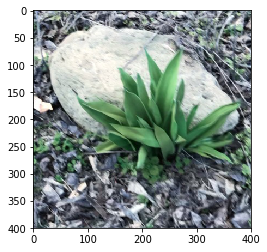

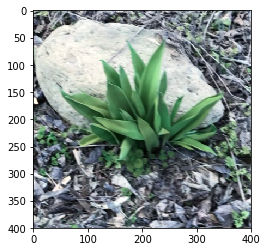

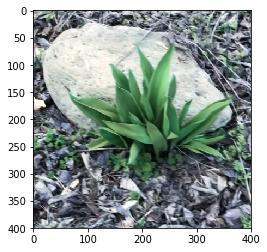

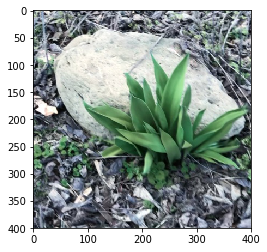

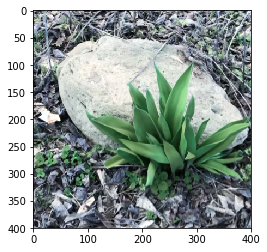

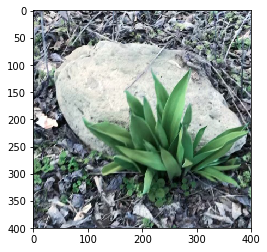

In [2]:
image_paths = [
"data/plant_images/24.jpg",
"data/plant_images/18.jpg",
"data/plant_images/21.jpg",
"data/plant_images/27.jpg",
"data/plant_images/33.jpg",
"data/plant_images/36.jpg"]

crop_row = 50
crop_col = 290
# crop the images to reduce computation time
raw_images = [mpimg.imread(path)[crop_row:crop_row+400,crop_col:crop_col + 400] for path in image_paths]

images = [im / 255.0 for im in raw_images ]
for im in images:
    plt.imshow(im)
    plt.show()


# Define optimization problem

In [3]:
tf.reset_default_graph()

reference_image = tf.cast(tf.constant(images[0]), tf.float32)
# create a batch dimension
reference_image = tf.expand_dims(reference_image, axis=0)

# ensure depth value is positive
depth =  tf.abs(tf.Variable(tf.ones(reference_image[...,0].shape)) + 1) +.1

tv_loss = tf.image.total_variation((tf.expand_dims((depth), axis=-1))) / (400**2) * .1

cost = tv_loss
warped_scene_images = []
for scene_image in images[1:]:
    scene_image = tf.cast(tf.constant(scene_image), tf.float32)
    scene_image = tf.expand_dims(scene_image, axis=0)

    # pose representation for the cameras that took each scene image
    translation_representation = tf.Variable([[0.01, 0.01, 0.01]])
    rotation_representation = tf.Variable([[0.01, 0.01, 0.01]])

    warped_scene_image = warp_image(scene_image, depth,
                                    translation_representation, rotation_representation)

    cost += tf.losses.huber_loss(warped_scene_image, reference_image)
    warped_scene_images.append(warped_scene_image)
    
optimizer = tf.train.AdamOptimizer(learning_rate=.005).minimize(cost)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
cost_value_history = []


# Run optimization

iteration 0


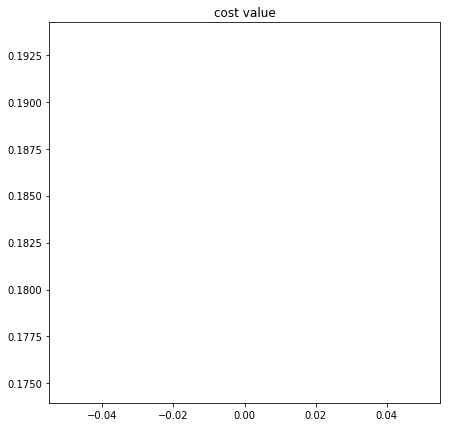

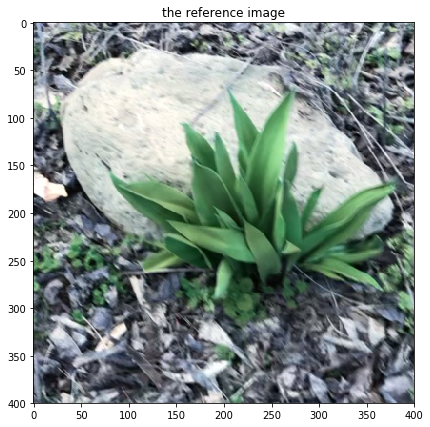

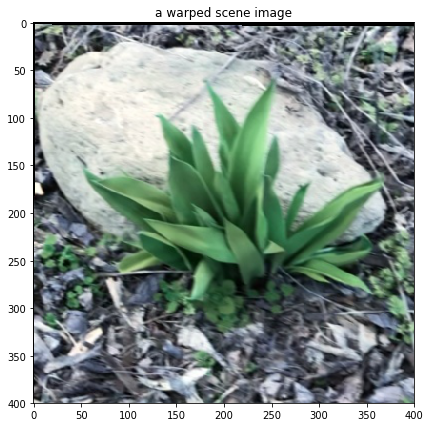

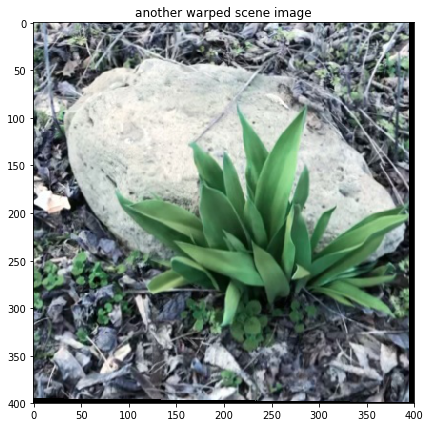

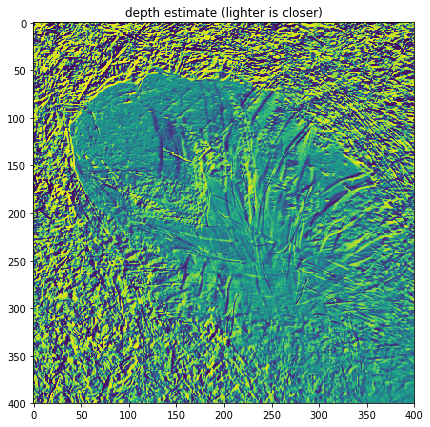

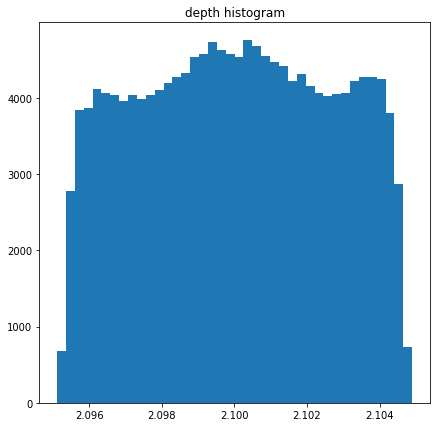

iteration 500


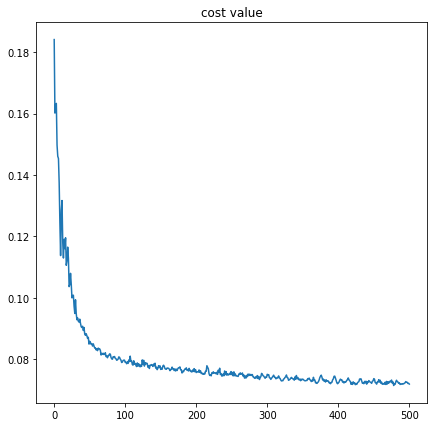

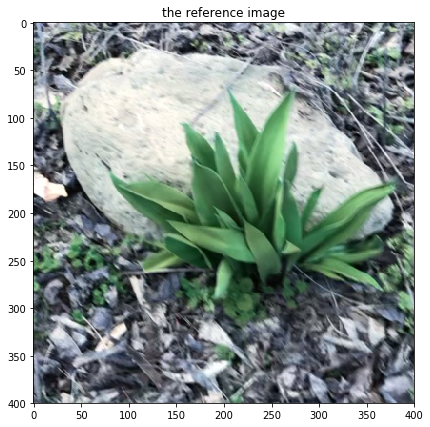

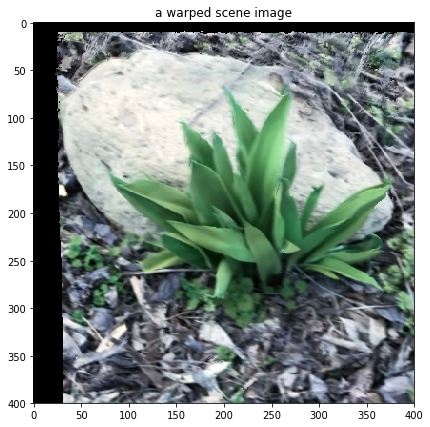

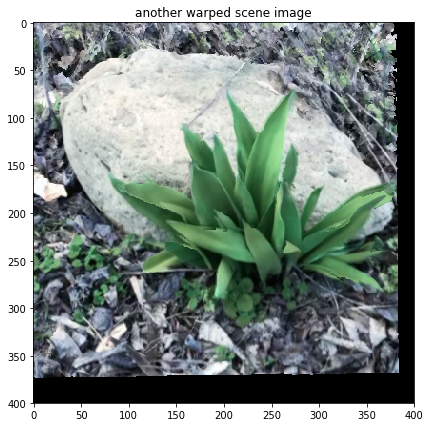

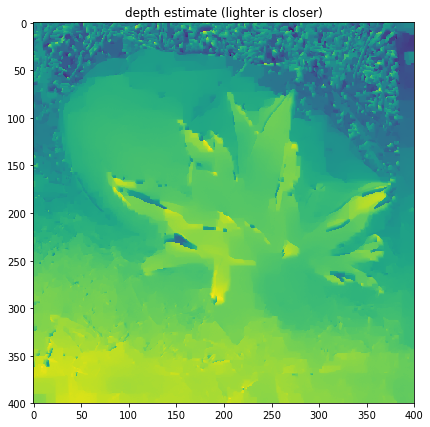

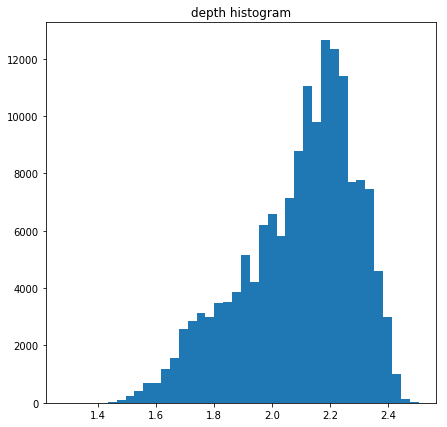

iteration 1000


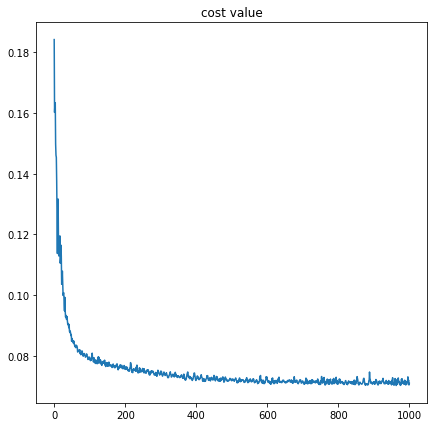

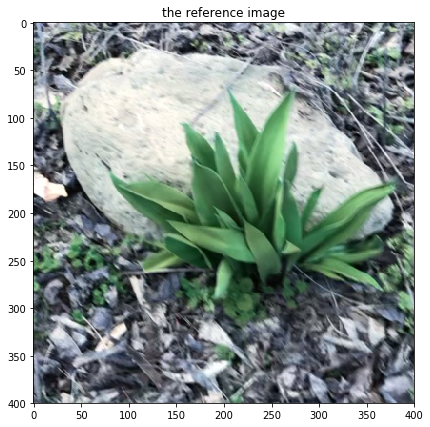

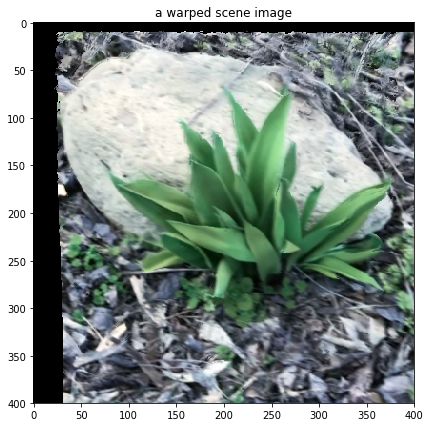

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


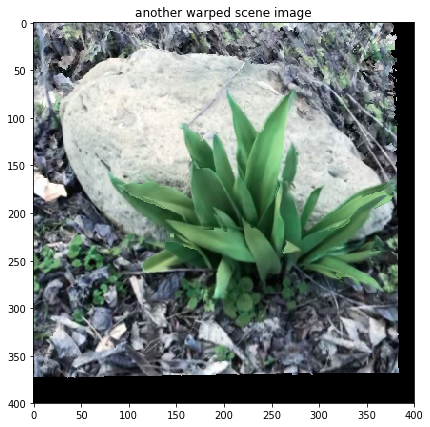

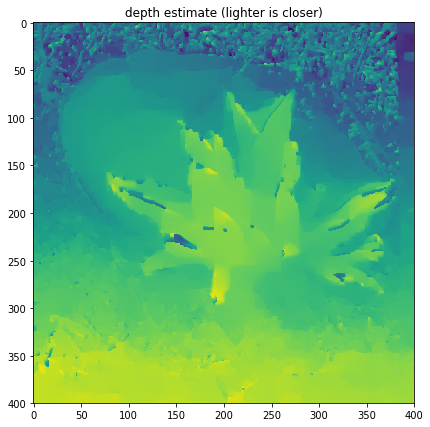

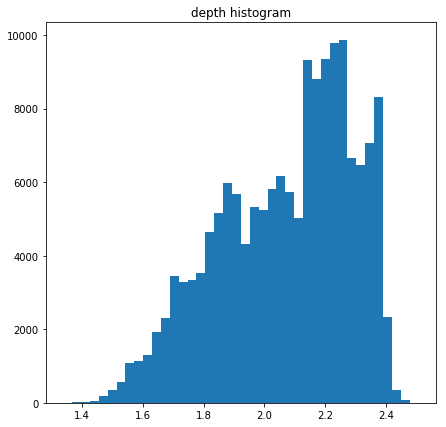

In [4]:
#make figures larger
matplotlib.rcParams['figure.figsize'] = [7, 7]

n_steps = 1000
for i in range(n_steps+1):
    _, loss_val = sess.run([optimizer,cost])
    cost_value_history.append(loss_val)
    
    if i % 500 ==0:
        print ("iteration", i)
        plt.plot(cost_value_history)
        plt.title("cost value")
        plt.show()
        
        reference_image_val, warped_scene_images_val, depth_val = sess.run(
            [reference_image, warped_scene_images, depth])
        
        plt.imshow(reference_image_val[0])
        plt.title("the reference image")
        plt.show()
        
        plt.imshow(warped_scene_images_val[0][0])
        plt.title("a warped scene image")
        plt.show()
        
        plt.title("another warped scene image")
        plt.imshow(warped_scene_images_val[3][0])
        plt.show()
        
        plt.imshow(sess.run(depth[0]))
        plt.title("depth estimate (lighter is closer)")
        plt.show()
        
        plt.hist(depth_val.flatten(), bins=40)
        plt.title("depth histogram")
        plt.show()
        
